In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from trajectories import TrajectoriesDataset, StateFullTrajectoriesDataset, preprocess_dataset, find_activations
from torch.utils.data import DataLoader
import os

%load_ext autoreload
%autoreload 2

In [2]:
positives = torch.load('data/MiniGrid-Triggers-3x3-T3P1-v0/random/trajectories/positive_train.pt')
negatives = torch.load('data/MiniGrid-Triggers-3x3-T3P1-v0/random/trajectories/negative_train.pt')
neutrals = torch.load('data/MiniGrid-Triggers-3x3-T3P1-v0/random/trajectories/neutral_train.pt')

max_neutrals = 3750

combined_obs = torch.vstack([positives.observations, negatives.observations, neutrals.observations[:max_neutrals]])
combined_act = torch.vstack([positives.actions, negatives.actions, neutrals.actions[:max_neutrals]])
combined_rew = torch.vstack([positives.rewards, negatives.rewards, neutrals.rewards[:max_neutrals]])

combined_obs.shape, combined_act.shape, combined_rew.shape

(torch.Size([4460, 50, 24, 24, 3]),
 torch.Size([4460, 50, 3]),
 torch.Size([4460, 50]))

In [3]:
test_combined = TrajectoriesDataset(combined_obs, combined_act, combined_rew)
torch.save(test_combined, 'data/MiniGrid-Triggers-3x3-T3P1-v0/random/trajectories/train_synth_4460.pt')
print(len(test_combined))


4460


Getting uniques..
Got uniques. Plotting...
Positive: 344 | Negative: 21068


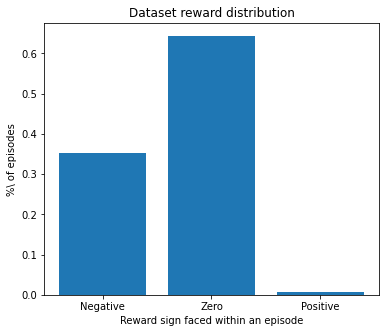

In [2]:
data_path = 'data/MiniGrid-Triggers-3x3-T3P1-v0/random/trajectories/test_60000.pt'
dataset = torch.load(data_path)

rewards = dataset.rewards

print('Getting uniques..')
unique_rewards_per_episode = [torch.unique(rewards[episode]).tolist() for episode in range(rewards.shape[0])]
print('Got uniques. Plotting...')

n_episodes_positive_reward = 0
n_episodes_negative_reward = 0
for episode_reward_vals in unique_rewards_per_episode:
    if 2 in episode_reward_vals:
        n_episodes_positive_reward += 1
    if 0 in episode_reward_vals:
        n_episodes_negative_reward += 1

n_episodes_no_reward = rewards.shape[0] - n_episodes_positive_reward - n_episodes_negative_reward
reward_vals = torch.tensor([n_episodes_negative_reward, n_episodes_no_reward, n_episodes_positive_reward])

print(f'Positive: {n_episodes_positive_reward} | Negative: {n_episodes_negative_reward}')


plt.figure(figsize=(6,5))
plt.title('Dataset reward distribution')
plt.xlabel('Reward sign faced within an episode')
plt.ylabel('%\ of episodes')
plt.bar(torch.arange(0, 3)-1, reward_vals/torch.sum(reward_vals), tick_label=['Negative', 'Zero', 'Positive'])
plt.show()


# del n_episodes_no_reward
# del dataset
# del rewards
# del reward_vals
# import gc
# gc.collect()

In [3]:
positive_episode_observations = []
positive_episode_actions = []
positive_episode_rewards = []

indices = []

for i, episode_reward_vals in enumerate(unique_rewards_per_episode):
    if 2 in episode_reward_vals:
        # episode with positive rewards, remember it
        indices.append(i)
        positive_episode_observations.append(dataset.observations[i])
        positive_episode_actions.append(dataset.actions[i])
        positive_episode_rewards.append(dataset.rewards[i])

print(len(positive_episode_observations))
print(indices)

344
[34, 301, 338, 354, 439, 957, 973, 1034, 1349, 1494, 1525, 2232, 2490, 2542, 2628, 3050, 3182, 3310, 3327, 3333, 3549, 3758, 3911, 3941, 4080, 4279, 4374, 4409, 4592, 5137, 5692, 5821, 5928, 5932, 6058, 6255, 6594, 6664, 6898, 6980, 7279, 7399, 7458, 8151, 8288, 8499, 8766, 9009, 9034, 9252, 9334, 9478, 9869, 10079, 10104, 10206, 10207, 10295, 10331, 10359, 10590, 10609, 11098, 11278, 11451, 11638, 11679, 11696, 11795, 12125, 12132, 12786, 12822, 12986, 13109, 13309, 13395, 13445, 13477, 13550, 13958, 14077, 14200, 14434, 14643, 14953, 15354, 15413, 15487, 16268, 16485, 16736, 16880, 16930, 16967, 17169, 17253, 17334, 17408, 17415, 17623, 18129, 18322, 18509, 18514, 18650, 19030, 19113, 19240, 19277, 19380, 19458, 19884, 20150, 20307, 20308, 20427, 20542, 20642, 20854, 21034, 21187, 21276, 21375, 21552, 21582, 21656, 22354, 22402, 22834, 22998, 23009, 23017, 23360, 23536, 23901, 24139, 24250, 24257, 24299, 24550, 25010, 25460, 26599, 26699, 26950, 27123, 27343, 27634, 27663, 27845,

In [4]:
positive_episode_observations[0].shape

torch.Size([50, 24, 24, 3])

In [5]:
positive_episode_observations = torch.stack(positive_episode_observations)
positive_episode_actions = torch.stack(positive_episode_actions)
positive_episode_rewards = torch.stack(positive_episode_rewards)

positive_dataset = TrajectoriesDataset(positive_episode_observations, positive_episode_actions, positive_episode_rewards)

In [6]:
torch.save(positive_dataset, 'data/MiniGrid-Triggers-3x3-T3P1-v0/random/trajectories/positive_test.pt')

In [7]:
negative_episode_observations = []
negative_episode_actions = []
negative_episode_rewards = []

indices = []

max_negatives = 400

for i, episode_reward_vals in enumerate(unique_rewards_per_episode):
    if 0 in episode_reward_vals:
        # episode with positive rewards, remember it
        indices.append(i)
        negative_episode_observations.append(dataset.observations[i])
        negative_episode_actions.append(dataset.actions[i])
        negative_episode_rewards.append(dataset.rewards[i])

        if len(negative_episode_observations) >= max_negatives:
            break

print(len(negative_episode_observations))
# print(indices)

400


In [8]:
negative_episode_observations = torch.stack(negative_episode_observations)
negative_episode_actions = torch.stack(negative_episode_actions)
negative_episode_rewards = torch.stack(negative_episode_rewards)

negative_dataset = TrajectoriesDataset(negative_episode_observations, negative_episode_actions, negative_episode_rewards)

In [9]:
torch.save(negative_dataset, 'data/MiniGrid-Triggers-3x3-T3P1-v0/random/trajectories/negative_test.pt')

In [13]:
neutral_episode_observations = []
neutral_episode_actions = []
neutral_episode_rewards = []

indices = []

max_neutrals = 4000

for i, episode_reward_vals in enumerate(unique_rewards_per_episode):
    if 1 in episode_reward_vals:
        # episode with positive rewards, remember it
        indices.append(i)
        neutral_episode_observations.append(dataset.observations[i])
        neutral_episode_actions.append(dataset.actions[i])
        neutral_episode_rewards.append(dataset.rewards[i])

        if len(neutral_episode_observations) >= max_neutrals:
            break

print(len(neutral_episode_observations))
# print(indices)

4000


In [14]:
neutral_episode_observations = torch.stack(neutral_episode_observations)
neutral_episode_actions = torch.stack(neutral_episode_actions)
neutral_episode_rewards = torch.stack(neutral_episode_rewards)

neutral_dataset = TrajectoriesDataset(neutral_episode_observations, neutral_episode_actions, neutral_episode_rewards)

In [15]:
torch.save(neutral_dataset, 'data/MiniGrid-Triggers-3x3-T3P1-v0/random/trajectories/neutral_test.pt')

action: tensor([0., 0., 1.])
reward: tensor(2)


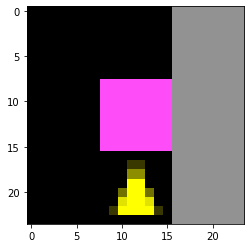

In [18]:
step = 45
plt.imshow(positive_episode_observations[0][step].type(torch.int32))
print('action:', positive_episode_actions[0][step])
print('reward:', positive_episode_rewards[0][step])

action: tensor([0., 0., 1.])
reward: tensor(0)


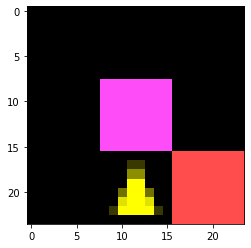

In [36]:
episode = 25
step = 41
plt.imshow(negative_dataset.observations[episode][step].type(torch.int32))
print('action:', negative_dataset.actions[episode][step])
print('reward:', negative_dataset.rewards[episode][step])